In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt 

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

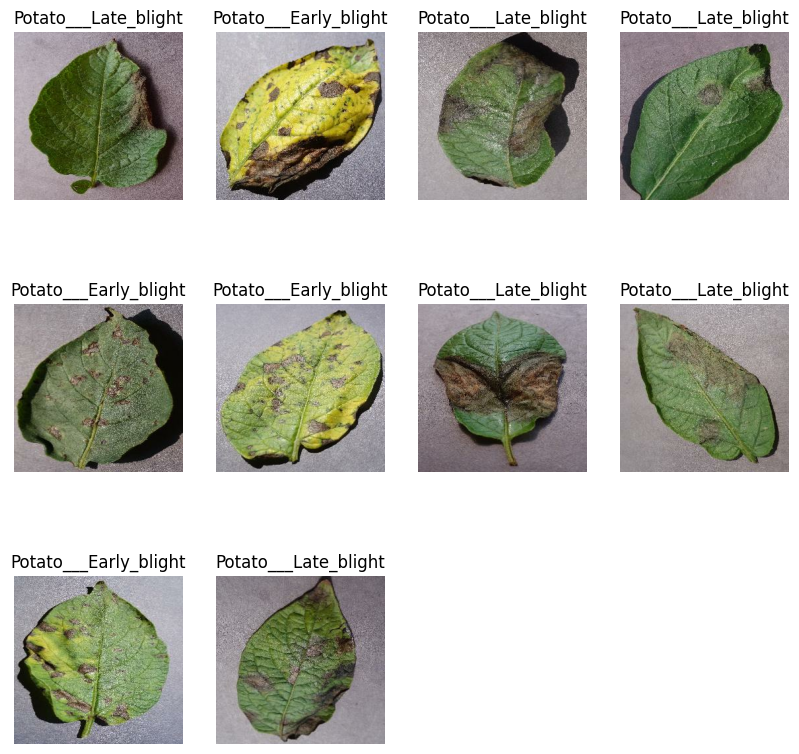

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print(image_batch[0].shape)
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split= 0.1, test_split= 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)   
    test_ds = ds.skip(train_size).skip(val_size)  
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
)

Epoch 1/50
54/54 [==============================] - 103s 2s/step - loss: 2.1918 - accuracy: 0.5689 - val_loss: 0.7854 - val_accuracy: 0.6562
Epoch 2/50
54/54 [==============================] - 88s 2s/step - loss: 0.5685 - accuracy: 0.7425 - val_loss: 0.4306 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 85s 2s/step - loss: 0.3548 - accuracy: 0.8495 - val_loss: 0.2745 - val_accuracy: 0.8958
Epoch 4/50
54/54 [==============================] - 87s 2s/step - loss: 0.2331 - accuracy: 0.9103 - val_loss: 0.2754 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 87s 2s/step - loss: 0.2508 - accuracy: 0.9039 - val_loss: 0.4201 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 105s 2s/step - loss: 0.1897 - accuracy: 0.9248 - val_loss: 0.2092 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 135s 3s/step - loss: 0.1800 - accuracy: 0.9294 - val_loss: 0.1700 - val_accuracy: 0.9375
Epoch 8/50
54/54 

In [28]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 6s 351ms/step - loss: 0.0131 - accuracy: 1.0000


[0.013145368546247482, 1.0]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['loss']

[2.1917552947998047,
 0.5685470104217529,
 0.354765921831131,
 0.23312422633171082,
 0.2507774531841278,
 0.18973375856876373,
 0.17997534573078156,
 0.1812104880809784,
 0.21335822343826294,
 0.27103564143180847,
 0.1731104701757431,
 0.16993294656276703,
 0.14159543812274933,
 0.15219992399215698,
 0.1554875522851944,
 0.14915163815021515,
 0.11413001269102097,
 0.1327240914106369,
 0.1498318761587143,
 0.09977064281702042,
 0.10852351039648056,
 0.14116185903549194,
 0.12250269949436188,
 0.14455687999725342,
 0.09425326436758041,
 0.08178700506687164,
 0.07330521941184998,
 0.09868074208498001,
 0.10561179369688034,
 0.0600329153239727,
 0.08324529230594635,
 0.07687105983495712,
 0.07480471581220627,
 0.0744832456111908,
 0.06288747489452362,
 0.06720951944589615,
 0.037540536373853683,
 0.08128731697797775,
 0.07478739321231842,
 0.08654284477233887,
 0.0656447559595108,
 0.03295566141605377,
 0.07244551926851273,
 0.06557583808898926,
 0.043288420885801315,
 0.03536266088485718,

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

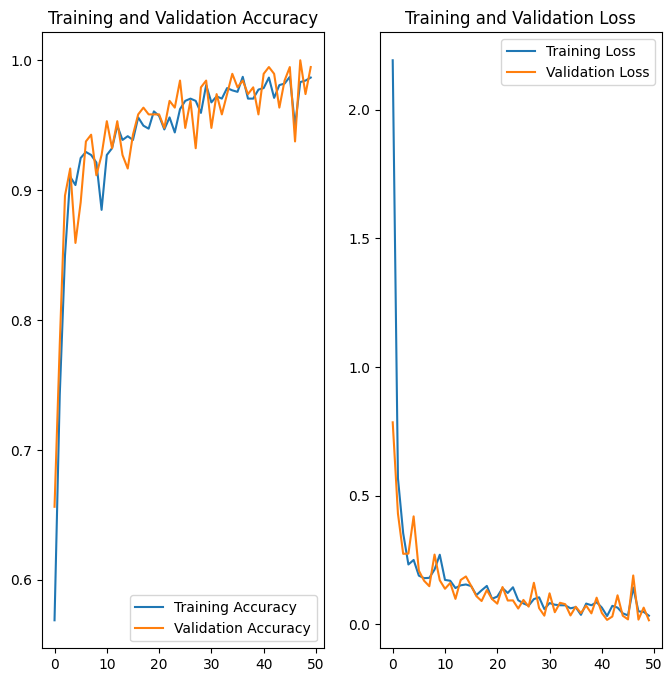

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 1s 1s/step
predicted label: Potato___healthy


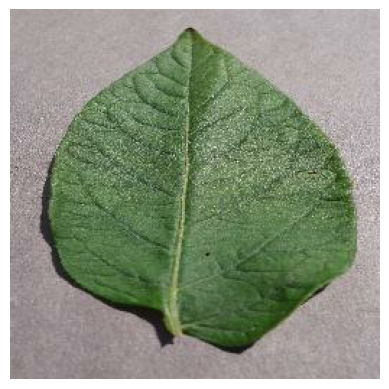

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [36]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


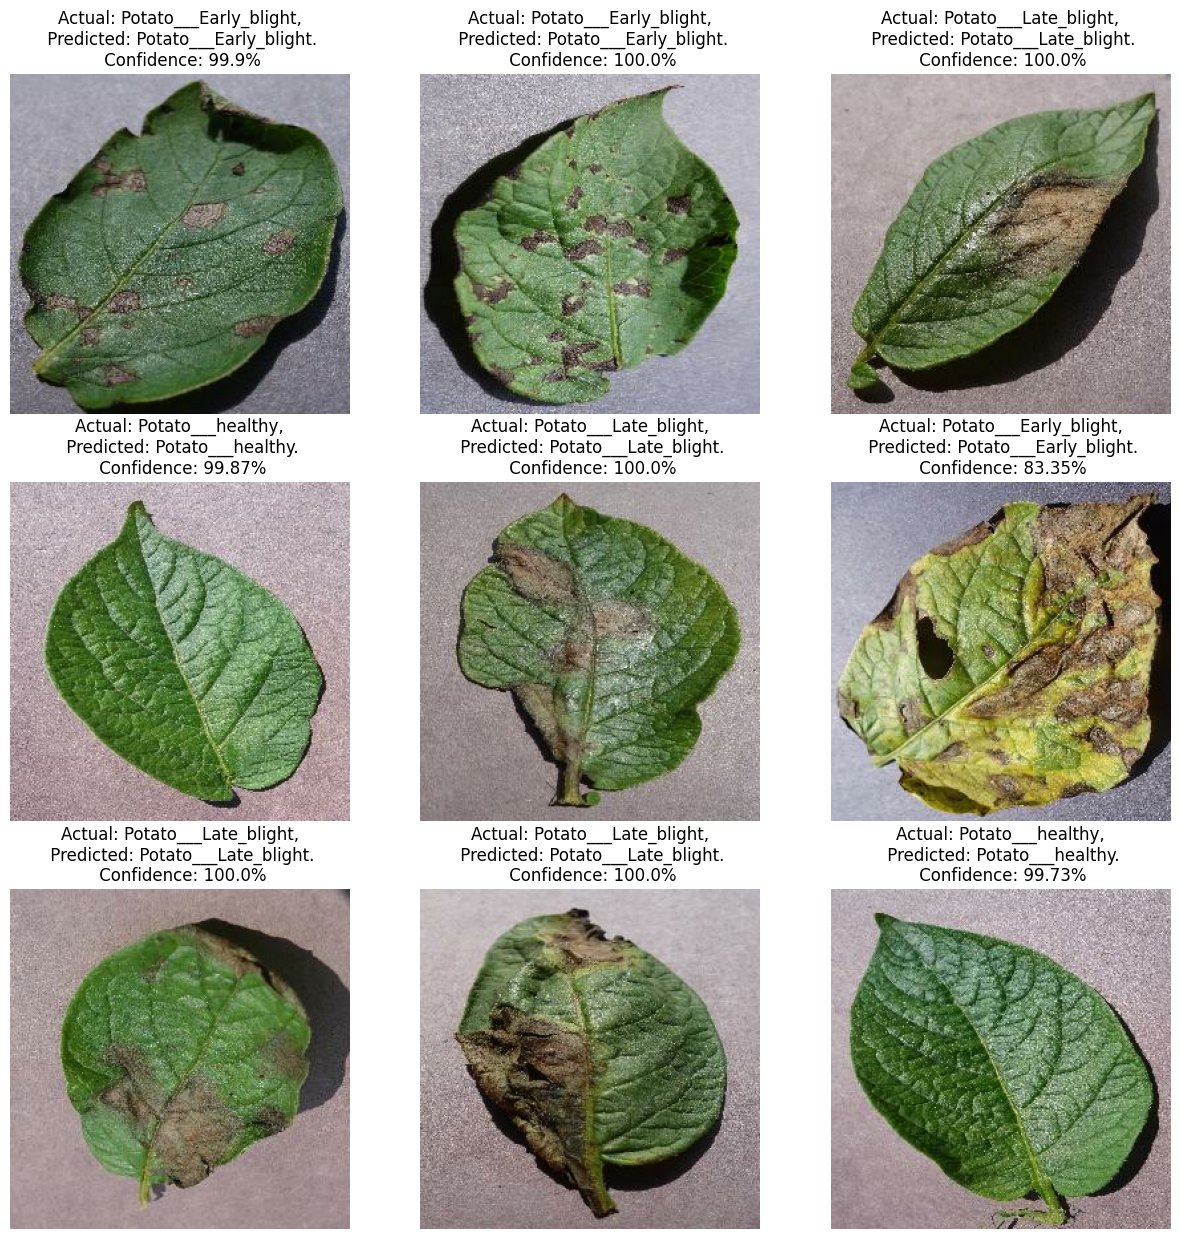

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [45]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [41]:
model.save("../model2best.keras")

Tanu
